In [1]:
from torchvision.models.feature_extraction import create_feature_extractor

import torch

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

from utils.dataset import Dataset

from scipy.stats import pearsonr as corr

from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression


In [2]:
batch_size = 64

In [3]:
data = Dataset('../../data/subj08')
#test_data = Dataset('../../data/subj08', test=True)

train_set, val_set = torch.utils.data.random_split(data, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

Loading dataset sample names...
Training images: 8779
Test images: 395

LH training fMRI data shape:
(8779, 18981)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20530)
(Training stimulus images × RH vertices)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
alexnet.to(device) # send the alexnet to the chosen device ('cpu' or 'cuda')
alexnet.eval() # set the alexnet to evaluation mode, since you are not training it

model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(alexnet, return_nodes=[model_layer])
feature_extractor.to(device)
feature_extractor.eval()

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [5]:
def fit_pca(feature_extractor, dataloader):
    # Define PCA parameters
    pca = IncrementalPCA(n_components=600, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        if _ == len(dataloader)-1:
            break
        # Extract features
        ft = feature_extractor(d[0].to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())

    return pca

In [6]:
pca = fit_pca(feature_extractor, train_loader)

  0%|          | 0/275 [00:01<?, ?it/s]


ValueError: n_components=600 must be less or equal to the batch number of samples 32.

In [ ]:
def extract_features(feature_extractor, dataloader, pca, right=False, test=False):
    fmri = []
    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        if test == False:
            ft = feature_extractor(d[0].to(device))
            if right == False:
                fmri += [d[1].cpu().detach().numpy()]
            else:
                fmri += [d[2].cpu().detach().numpy()]
        else:
            ft = feature_extractor(d.to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features += [ft]
    if test == False:
        return (np.vstack(features), np.vstack(fmri))
    return np.vstack(features)

In [8]:
right = False

features_train, labels_train = extract_features(feature_extractor, train_loader, pca, right=right)
features_val, labels_val = extract_features(feature_extractor, val_loader, pca, right=right)

100%|██████████| 3/3 [00:17<00:00,  5.90s/it]


In [13]:
class RegressionHead(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(RegressionHead, self).__init__()

        self.flatten = torch.nn.Flatten()

        self.linear1 = torch.nn.Linear(inputSize, 6000)
        self.linear2 = torch.nn.Linear(6000, outputSize)

    def forward(self, x):
        flattened = self.flatten(x)

        output = self.linear1(flattened)

        return self.linear2(output)

In [14]:
regression_head = RegressionHead(46656, 18981).to(device)
regression_head.to(device)

RegressionHead(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=46656, out_features=6000, bias=True)
  (linear2): Linear(in_features=6000, out_features=18981, bias=True)
)

In [15]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)

In [16]:
losses = []
val_losses = []

for epoch in range(100):
    print(f"Epoch {epoch}")
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)-1):
        optimizer.zero_grad()

        input_data = data[0]
        left_label = data[1]

        with torch.no_grad():
            output = feature_extractor(input_data.to(device))
        
        output = regression_head(output["features.2"])

        loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
        
        if i == len(train_loader)-1:
            losses.append(loss.item())
            print("Train loss: " + str(loss.item()))

        loss.backward()

        del input_data
        del left_label
        
        optimizer.step()
    
    for i, data in tqdm(enumerate(val_loader), total=len(val_loader)-1):
        input_data = data[0]
        left_label = data[1]

        with torch.no_grad():
            output = feature_extractor(input_data.to(device))
            output = regression_head(output["features.2"])

        loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))

        del input_data
        del left_label
        
        if i == len(val_loader)-1:
            val_losses.append(loss.item())
            print("Val loss: " + str(loss.item()))

Epoch 0


  0%|          | 0/137 [00:00<?, ?it/s]/tmp/ipykernel_10414/1485731101.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
138it [01:27,  1.58it/s]                         


Train loss: 0.45770904421806335


  0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_10414/1485731101.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
28it [00:17,  1.62it/s]                        


Val loss: 0.5925355553627014
Epoch 1


138it [01:26,  1.59it/s]                         


Train loss: 0.8026808500289917


28it [00:17,  1.59it/s]                        


Val loss: 0.6910714507102966
Epoch 2


138it [01:26,  1.60it/s]                         


Train loss: 0.5864574313163757


28it [00:17,  1.62it/s]                        


Val loss: 0.472219854593277
Epoch 3


138it [01:26,  1.59it/s]                         


Train loss: 0.5414307117462158


28it [00:17,  1.62it/s]                        


Val loss: 0.5181928873062134
Epoch 4


138it [01:27,  1.58it/s]                         


Train loss: 0.4237147867679596


28it [00:17,  1.59it/s]                        


Val loss: 0.6518995761871338
Epoch 5


138it [01:26,  1.59it/s]                         


Train loss: 0.47206389904022217


28it [00:17,  1.63it/s]                        


Val loss: 0.5444388389587402
Epoch 6


138it [01:25,  1.61it/s]                         


Train loss: 0.48762160539627075


28it [00:17,  1.63it/s]                        


Val loss: 0.5048766136169434
Epoch 7


138it [01:25,  1.61it/s]                         


Train loss: 0.4185165464878082


28it [00:17,  1.62it/s]                        


Val loss: 0.5054435133934021
Epoch 8


138it [01:25,  1.61it/s]                         


Train loss: 0.5146732926368713


28it [00:17,  1.63it/s]                        


Val loss: 0.5105953812599182
Epoch 9


138it [01:25,  1.61it/s]                         


Train loss: 0.4533761739730835


28it [00:17,  1.62it/s]                        


Val loss: 0.39457809925079346
Epoch 10


138it [01:25,  1.61it/s]                         


Train loss: 0.4535479247570038


28it [00:17,  1.63it/s]                        


Val loss: 0.4926818907260895
Epoch 11


138it [01:25,  1.61it/s]                         


Train loss: 0.628699004650116


28it [00:17,  1.62it/s]                        


Val loss: 0.4502503275871277
Epoch 12


138it [01:26,  1.60it/s]                         


Train loss: 0.43044742941856384


28it [00:17,  1.61it/s]                        


Val loss: 0.3623460829257965
Epoch 13


138it [01:26,  1.59it/s]                         


Train loss: 0.47481468319892883


28it [00:17,  1.61it/s]                        


Val loss: 0.4168318510055542
Epoch 14


138it [01:26,  1.59it/s]                         


Train loss: 0.36793574690818787


28it [00:17,  1.63it/s]                        


Val loss: 0.4201178550720215
Epoch 15


138it [01:25,  1.61it/s]                         


Train loss: 0.40719181299209595


28it [00:17,  1.61it/s]                        


Val loss: 0.39712271094322205
Epoch 16


138it [01:26,  1.60it/s]                         


Train loss: 0.32385000586509705


28it [00:17,  1.60it/s]                        


Val loss: 0.3922369182109833
Epoch 17


138it [01:26,  1.60it/s]                         


Train loss: 0.38848739862442017


28it [00:17,  1.62it/s]                        


Val loss: 0.39161601662635803
Epoch 18


138it [01:25,  1.61it/s]                         


Train loss: 0.40904611349105835


28it [00:17,  1.62it/s]                        


Val loss: 0.35452091693878174
Epoch 19


138it [01:26,  1.60it/s]                         


Train loss: 0.42096516489982605


28it [00:17,  1.63it/s]                        


Val loss: 0.3944772779941559
Epoch 20


138it [01:25,  1.60it/s]                         


Train loss: 0.42975541949272156


28it [00:17,  1.63it/s]                        


Val loss: 0.3870912194252014
Epoch 21


138it [01:26,  1.60it/s]                         


Train loss: 0.4142124056816101


28it [00:17,  1.61it/s]                        


Val loss: 0.401576429605484
Epoch 22


138it [01:27,  1.58it/s]                         


Train loss: 0.2648771405220032


28it [00:17,  1.60it/s]                        


Val loss: 0.35796573758125305
Epoch 23


138it [01:26,  1.60it/s]                         


Train loss: 0.29960864782333374


28it [00:17,  1.61it/s]                        


Val loss: 0.3270431458950043
Epoch 24


138it [01:26,  1.59it/s]                         


Train loss: 0.3346700370311737


28it [00:17,  1.61it/s]                        


Val loss: 0.37626752257347107
Epoch 25


138it [01:27,  1.58it/s]                         


Train loss: 0.2918616235256195


28it [00:17,  1.58it/s]                        


Val loss: 0.31559431552886963
Epoch 26


138it [01:26,  1.59it/s]                         


Train loss: 0.43801695108413696


28it [00:17,  1.62it/s]                        


Val loss: 0.32581040263175964
Epoch 27


138it [01:25,  1.61it/s]                         


Train loss: 0.29054126143455505


28it [00:17,  1.58it/s]                        


Val loss: 0.3257181942462921
Epoch 28


138it [01:26,  1.60it/s]                         


Train loss: 0.2815552055835724


28it [00:17,  1.62it/s]                        


Val loss: 0.32702720165252686
Epoch 29


138it [01:26,  1.60it/s]                         


Train loss: 0.23602242767810822


28it [00:17,  1.62it/s]                        


Val loss: 0.30282899737358093
Epoch 30


138it [01:26,  1.60it/s]                         


Train loss: 0.31027117371559143


28it [00:17,  1.61it/s]                        


Val loss: 0.2632519006729126
Epoch 31


138it [01:26,  1.60it/s]                         


Train loss: 0.35434144735336304


28it [00:17,  1.60it/s]                        


Val loss: 0.2716621458530426
Epoch 32


138it [01:26,  1.59it/s]                         


Train loss: 0.3899037539958954


28it [00:17,  1.62it/s]                        


Val loss: 0.25915902853012085
Epoch 33


138it [01:25,  1.60it/s]                         


Train loss: 0.28463292121887207


28it [00:17,  1.62it/s]                        


Val loss: 0.3222790062427521
Epoch 34


138it [01:26,  1.60it/s]                         


Train loss: 0.19405436515808105


28it [00:17,  1.61it/s]                        


Val loss: 0.24489063024520874
Epoch 35


138it [01:26,  1.60it/s]                         


Train loss: 0.36075499653816223


28it [00:17,  1.59it/s]                        


Val loss: 0.2811453342437744
Epoch 36


138it [01:26,  1.60it/s]                         


Train loss: 0.29527053236961365


28it [00:17,  1.62it/s]                        


Val loss: 0.23925043642520905
Epoch 37


138it [01:26,  1.59it/s]                         


Train loss: 0.23318734765052795


28it [00:17,  1.62it/s]                        


Val loss: 0.33472737669944763
Epoch 38


138it [01:26,  1.59it/s]                         


Train loss: 0.27099892497062683


28it [00:17,  1.62it/s]                        


Val loss: 0.27791887521743774
Epoch 39


138it [01:26,  1.60it/s]                         


Train loss: 0.20586960017681122


28it [00:17,  1.62it/s]                        


Val loss: 0.23282475769519806
Epoch 40


138it [01:26,  1.60it/s]                         


Train loss: 0.22356173396110535


28it [00:17,  1.63it/s]                        


Val loss: 0.25076496601104736
Epoch 41


138it [01:25,  1.61it/s]                         


Train loss: 0.23353832960128784


28it [00:17,  1.62it/s]                        


Val loss: 0.2890247106552124
Epoch 42


138it [01:26,  1.59it/s]                         


Train loss: 0.17801420390605927


28it [00:17,  1.62it/s]                        


Val loss: 0.21560153365135193
Epoch 43


138it [01:25,  1.61it/s]                         


Train loss: 0.1823754757642746


28it [00:17,  1.62it/s]                        


Val loss: 0.24441233277320862
Epoch 44


138it [01:26,  1.60it/s]                         


Train loss: 0.20440630614757538


28it [00:17,  1.62it/s]                        


Val loss: 0.2803117632865906
Epoch 45


138it [01:26,  1.59it/s]                         


Train loss: 0.20589332282543182


28it [00:17,  1.62it/s]                        


Val loss: 0.20586338639259338
Epoch 46


138it [01:25,  1.61it/s]                         


Train loss: 0.1845838874578476


28it [00:17,  1.63it/s]                        


Val loss: 0.19498836994171143
Epoch 47


138it [01:26,  1.60it/s]                         


Train loss: 0.18919672071933746


28it [00:17,  1.61it/s]                        


Val loss: 0.21959711611270905
Epoch 48


138it [01:26,  1.60it/s]                         


Train loss: 0.2033982276916504


28it [00:17,  1.61it/s]                        


Val loss: 0.19410789012908936
Epoch 49


138it [01:26,  1.60it/s]                         


Train loss: 0.17227473855018616


28it [00:17,  1.61it/s]                        


Val loss: 0.17286768555641174
Epoch 50


138it [01:26,  1.60it/s]                         


Train loss: 0.19744089245796204


28it [00:17,  1.63it/s]                        


Val loss: 0.17560318112373352
Epoch 51


138it [01:26,  1.60it/s]                         


Train loss: 0.16567352414131165


28it [00:17,  1.62it/s]                        


Val loss: 0.22181405127048492
Epoch 52


138it [01:25,  1.61it/s]                         


Train loss: 0.19030506908893585


28it [00:17,  1.63it/s]                        


Val loss: 0.17864243686199188
Epoch 53


138it [01:25,  1.61it/s]                         


Train loss: 0.15455754101276398


28it [00:17,  1.62it/s]                        


Val loss: 0.17802749574184418
Epoch 54


138it [01:25,  1.61it/s]                         


Train loss: 1.1244086027145386


28it [00:17,  1.62it/s]                        


Val loss: 1.1804826259613037
Epoch 55


138it [01:25,  1.61it/s]                         


Train loss: 0.22762884199619293


28it [00:17,  1.62it/s]                        


Val loss: 0.20033709704875946
Epoch 56


138it [01:25,  1.61it/s]                         


Train loss: 0.15614144504070282


28it [00:17,  1.61it/s]                        


Val loss: 0.1822284460067749
Epoch 57


138it [01:26,  1.60it/s]                         


Train loss: 0.16800737380981445


28it [00:17,  1.61it/s]                        


Val loss: 0.14816704392433167
Epoch 58


138it [01:26,  1.60it/s]                         


Train loss: 0.1679299920797348


28it [00:17,  1.62it/s]                        


Val loss: 0.17100617289543152
Epoch 59


138it [01:26,  1.60it/s]                         


Train loss: 0.14719092845916748


28it [00:17,  1.63it/s]                        


Val loss: 0.13274340331554413
Epoch 60


138it [01:26,  1.60it/s]                         


Train loss: 0.12763099372386932


28it [00:17,  1.62it/s]                        


Val loss: 0.21482017636299133
Epoch 61


138it [01:26,  1.60it/s]                         


Train loss: 0.1458965688943863


28it [00:17,  1.59it/s]                        


Val loss: 0.1288101077079773
Epoch 62


138it [01:26,  1.59it/s]                         


Train loss: 0.1170610710978508


28it [00:17,  1.62it/s]                        


Val loss: 0.15179350972175598
Epoch 63


138it [01:26,  1.60it/s]                         


Train loss: 0.1325586438179016


28it [00:17,  1.62it/s]                        


Val loss: 0.20247913897037506
Epoch 64


138it [01:26,  1.59it/s]                         


Train loss: 0.1735323667526245


28it [00:17,  1.59it/s]                        


Val loss: 0.13839198648929596
Epoch 65


138it [01:26,  1.59it/s]                         


Train loss: 0.14799723029136658


28it [00:17,  1.62it/s]                        


Val loss: 0.14991328120231628
Epoch 66


138it [01:26,  1.60it/s]                         


Train loss: 0.14785197377204895


28it [00:17,  1.60it/s]                        


Val loss: 0.1269710659980774
Epoch 67


138it [01:26,  1.60it/s]                         


Train loss: 0.11952372640371323


28it [00:17,  1.61it/s]                        


Val loss: 0.13384608924388885
Epoch 68


138it [01:26,  1.60it/s]                         


Train loss: 0.10327113419771194


28it [00:17,  1.63it/s]                        


Val loss: 0.12012289464473724
Epoch 69


138it [01:25,  1.61it/s]                         


Train loss: 0.15889078378677368


28it [00:17,  1.62it/s]                        


Val loss: 0.15884876251220703
Epoch 70


138it [01:25,  1.61it/s]                         


Train loss: 0.12332912534475327


28it [00:17,  1.61it/s]                        


Val loss: 0.11895463615655899
Epoch 71


138it [01:25,  1.61it/s]                         


Train loss: 0.12658686935901642


28it [00:17,  1.61it/s]                        


Val loss: 0.13617756962776184
Epoch 72


138it [01:25,  1.60it/s]                         


Train loss: 0.16195985674858093


28it [00:17,  1.60it/s]                        


Val loss: 0.18230128288269043
Epoch 73


138it [01:26,  1.59it/s]                         


Train loss: 0.16741439700126648


28it [00:17,  1.61it/s]                        


Val loss: 0.20790335536003113
Epoch 74


138it [01:26,  1.60it/s]                         


Train loss: 0.1180245578289032


28it [00:17,  1.61it/s]                        


Val loss: 0.1790533810853958
Epoch 75


138it [01:26,  1.60it/s]                         


Train loss: 0.11426188051700592


28it [00:17,  1.62it/s]                        


Val loss: 0.11470010876655579
Epoch 76


138it [01:26,  1.59it/s]                         


Train loss: 0.1099960058927536


28it [00:17,  1.60it/s]                        


Val loss: 0.13442844152450562
Epoch 77


138it [01:26,  1.59it/s]                         


Train loss: 0.14422805607318878


28it [00:17,  1.61it/s]                        


Val loss: 0.1442033350467682
Epoch 78


138it [01:26,  1.59it/s]                         


Train loss: 0.13358666002750397


28it [00:17,  1.62it/s]                        


Val loss: 0.16623950004577637
Epoch 79


138it [01:26,  1.60it/s]                         


Train loss: 0.12415964156389236


28it [00:17,  1.63it/s]                        


Val loss: 0.1698351800441742
Epoch 80


138it [01:26,  1.60it/s]                         


Train loss: 0.13292741775512695


28it [00:17,  1.62it/s]                        


Val loss: 0.13692393898963928
Epoch 81


138it [01:26,  1.60it/s]                         


Train loss: 0.12104200571775436


28it [00:17,  1.62it/s]                        


Val loss: 0.13585247099399567
Epoch 82


138it [01:26,  1.59it/s]                         


Train loss: 0.11182297021150589


28it [00:17,  1.61it/s]                        


Val loss: 0.14991487562656403
Epoch 83


138it [01:26,  1.60it/s]                         


Train loss: 0.1617031991481781


28it [00:17,  1.62it/s]                        


Val loss: 0.1420789361000061
Epoch 84


138it [01:26,  1.60it/s]                         


Train loss: 0.12579602003097534


28it [00:17,  1.63it/s]                        


Val loss: 0.15152719616889954
Epoch 85


138it [01:26,  1.60it/s]                         


Train loss: 0.11501387506723404


28it [00:17,  1.62it/s]                        


Val loss: 0.1464609056711197
Epoch 86


138it [01:26,  1.60it/s]                         


Train loss: 0.10629286617040634


28it [00:17,  1.60it/s]                        


Val loss: 0.16755713522434235
Epoch 87


138it [01:26,  1.60it/s]                         


Train loss: 0.1541094332933426


28it [00:17,  1.61it/s]                        


Val loss: 0.11667701601982117
Epoch 88


138it [01:26,  1.59it/s]                         


Train loss: 0.1367173194885254


28it [00:17,  1.59it/s]                        


Val loss: 0.11121215671300888
Epoch 89


138it [01:26,  1.60it/s]                         


Train loss: 0.1141185313463211


28it [00:17,  1.62it/s]                        


Val loss: 0.14116017520427704
Epoch 90


138it [01:26,  1.60it/s]                         


Train loss: 0.09185009449720383


28it [00:17,  1.63it/s]                        


Val loss: 0.11656200140714645
Epoch 91


138it [01:25,  1.61it/s]                         


Train loss: 0.11923716217279434


28it [00:17,  1.62it/s]                        


Val loss: 0.1180838942527771
Epoch 92


138it [01:25,  1.61it/s]                         


Train loss: 0.14436498284339905


28it [00:17,  1.61it/s]                        


Val loss: 0.13621585071086884
Epoch 93


138it [01:26,  1.60it/s]                         


Train loss: 0.12999765574932098


28it [00:17,  1.61it/s]                        


Val loss: 0.12857283651828766
Epoch 94


138it [01:26,  1.60it/s]                         


Train loss: 0.10101340711116791


28it [00:17,  1.62it/s]                        


Val loss: 0.14155274629592896
Epoch 95


138it [01:26,  1.60it/s]                         


Train loss: 0.10382285714149475


28it [00:17,  1.61it/s]                        


Val loss: 0.12688574194908142
Epoch 96


138it [01:26,  1.60it/s]                         


Train loss: 0.08630093187093735


28it [00:17,  1.62it/s]                        


Val loss: 0.13117346167564392
Epoch 97


138it [01:26,  1.60it/s]                         


Train loss: 0.12263484299182892


28it [00:17,  1.61it/s]                        


Val loss: 0.1519266664981842
Epoch 98


138it [01:26,  1.59it/s]                         


Train loss: 0.1146477609872818


28it [00:17,  1.61it/s]                        


Val loss: 0.15735886991024017
Epoch 99


138it [01:26,  1.59it/s]                         


Train loss: 0.09389741718769073


28it [00:17,  1.62it/s]                        

Val loss: 0.12801849842071533


In [9]:
losses = []
val_losses = []

for epoch in range(100):
    print(f"Epoch {epoch}")
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)-1):
        optimizer.zero_grad()

        input_data = data[0]
        left_label = data[1]

        with torch.no_grad():
            output = feature_extractor(input_data.to(device))
        
        output = regression_head(output["features.2"])

        loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
        
        if i == len(train_loader)-1:
            losses.append(loss.item())
            print("Train loss: " + str(loss.item()))

        loss.backward()

        del input_data
        del left_label
        
        optimizer.step()
    
    for i, data in tqdm(enumerate(val_loader), total=len(val_loader)-1):
        input_data = data[0]
        left_label = data[1]

        with torch.no_grad():
            output = feature_extractor(input_data.to(device))
            output = regression_head(output["features.2"])

        loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))

        del input_data
        del left_label
        
        if i == len(val_loader)-1:
            val_losses.append(loss.item())
            print("Val loss: " + str(loss.item()))

Epoch 0


  0%|          | 0/137 [00:00<?, ?it/s]/tmp/ipykernel_10414/1485731101.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
138it [01:26,  1.60it/s]                         


Train loss: 0.5491150617599487


  0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_10414/1485731101.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
28it [00:17,  1.61it/s]                        


Val loss: 0.5460406541824341
Epoch 1


138it [01:25,  1.61it/s]                         


Train loss: 0.435117244720459


28it [00:17,  1.63it/s]                        


Val loss: 0.5733707547187805
Epoch 2


138it [01:25,  1.61it/s]                         


Train loss: 0.6132146716117859


28it [00:17,  1.62it/s]                        


Val loss: 0.5243082046508789
Epoch 3


138it [01:25,  1.61it/s]                         


Train loss: 0.47271794080734253


28it [00:17,  1.63it/s]                        


Val loss: 0.5616840124130249
Epoch 4


138it [01:26,  1.59it/s]                         


Train loss: 0.4526216387748718


28it [00:17,  1.62it/s]                        


Val loss: 0.574997067451477
Epoch 5


138it [01:25,  1.61it/s]                         


Train loss: 0.44867590069770813


28it [00:17,  1.61it/s]                        


Val loss: 0.6027223467826843
Epoch 6


138it [01:25,  1.61it/s]                         


Train loss: 0.6809962391853333


28it [00:17,  1.62it/s]                        


Val loss: 0.5843181610107422
Epoch 7


138it [01:26,  1.59it/s]                         


Train loss: 0.49060672521591187


28it [00:17,  1.62it/s]                        


Val loss: 0.4012402594089508
Epoch 8


138it [01:25,  1.61it/s]                         


Train loss: 0.566413938999176


28it [00:17,  1.63it/s]                        


Val loss: 0.45566868782043457
Epoch 9


138it [01:25,  1.61it/s]                         


Train loss: 0.4270640015602112


28it [00:17,  1.63it/s]                        


Val loss: 0.5163838267326355
Epoch 10


138it [01:25,  1.61it/s]                         


Train loss: 0.4610077440738678


28it [00:17,  1.63it/s]                        


Val loss: 0.4923304319381714
Epoch 11


138it [01:25,  1.61it/s]                         


Train loss: 0.4072680175304413


28it [00:17,  1.63it/s]                        


Val loss: 0.425993949174881
Epoch 12


138it [01:25,  1.61it/s]                         


Train loss: 0.5621489882469177


28it [00:17,  1.62it/s]                        


Val loss: 0.42860785126686096
Epoch 13


138it [01:25,  1.61it/s]                         


Train loss: 0.5039610862731934


28it [00:17,  1.62it/s]                        


Val loss: 0.4967416226863861
Epoch 14


138it [01:25,  1.61it/s]                         


Train loss: 0.5642749667167664


28it [00:17,  1.63it/s]                        


Val loss: 0.4275646209716797
Epoch 15


138it [01:25,  1.61it/s]                         


Train loss: 0.3639109432697296


28it [00:17,  1.62it/s]                        


Val loss: 0.39239612221717834
Epoch 16


138it [01:25,  1.61it/s]                         


Train loss: 0.43589770793914795


28it [00:17,  1.63it/s]                        


Val loss: 0.47600892186164856
Epoch 17


138it [01:25,  1.61it/s]                         


Train loss: 0.542448103427887


28it [00:17,  1.61it/s]                        


Val loss: 0.44788292050361633
Epoch 18


138it [01:26,  1.60it/s]                         


Train loss: 0.32617732882499695


28it [00:17,  1.63it/s]                        


Val loss: 0.34185338020324707
Epoch 19


138it [01:26,  1.60it/s]                         


Train loss: 0.33001911640167236


28it [00:17,  1.63it/s]                        


Val loss: 0.450908362865448
Epoch 20


138it [01:25,  1.61it/s]                         


Train loss: 0.504726767539978


28it [00:17,  1.61it/s]                        


Val loss: 0.3601134419441223
Epoch 21


138it [01:26,  1.60it/s]                         


Train loss: 0.36744993925094604


28it [00:17,  1.63it/s]                        


Val loss: 0.4082871377468109
Epoch 22


138it [01:26,  1.60it/s]                         


Train loss: 0.35505610704421997


28it [00:17,  1.64it/s]                        


Val loss: 0.3433329463005066
Epoch 23


138it [01:26,  1.60it/s]                         


Train loss: 0.33619147539138794


28it [00:17,  1.62it/s]                        


Val loss: 0.4611721336841583
Epoch 24


138it [01:25,  1.61it/s]                         


Train loss: 0.2744985520839691


28it [00:17,  1.63it/s]                        


Val loss: 0.3223233222961426
Epoch 25


138it [01:26,  1.60it/s]                         


Train loss: 0.3678610622882843


28it [00:17,  1.62it/s]                        


Val loss: 0.40219321846961975
Epoch 26


138it [01:26,  1.59it/s]                         


Train loss: 0.33228227496147156


28it [00:17,  1.63it/s]                        


Val loss: 0.3993688225746155
Epoch 27


138it [01:25,  1.60it/s]                         


Train loss: 0.45147818326950073


28it [00:17,  1.61it/s]                        


Val loss: 0.375662624835968
Epoch 28


138it [01:26,  1.60it/s]                         


Train loss: 0.3217325508594513


28it [00:17,  1.63it/s]                        


Val loss: 0.33868208527565
Epoch 29


138it [01:26,  1.60it/s]                         


Train loss: 0.2951941192150116


28it [00:17,  1.62it/s]                        


Val loss: 0.3133053481578827
Epoch 30


138it [01:26,  1.60it/s]                         


Train loss: 0.30664336681365967


28it [00:17,  1.62it/s]                        


Val loss: 0.33165913820266724
Epoch 31


138it [01:26,  1.60it/s]                         


Train loss: 0.38118696212768555


28it [00:17,  1.63it/s]                        


Val loss: 0.3888019323348999
Epoch 32


138it [01:25,  1.61it/s]                         


Train loss: 0.33795541524887085


28it [00:17,  1.61it/s]                        


Val loss: 0.38209399580955505
Epoch 33


138it [01:26,  1.59it/s]                         


Train loss: 0.30558547377586365


28it [00:17,  1.62it/s]                        


Val loss: 0.28765884041786194
Epoch 34


138it [01:26,  1.60it/s]                         


Train loss: 0.36590954661369324


28it [00:17,  1.61it/s]                        


Val loss: 0.41672977805137634
Epoch 35


138it [01:25,  1.61it/s]                         


Train loss: 0.33823028206825256


28it [00:17,  1.61it/s]                        


Val loss: 0.29285791516304016
Epoch 36


138it [01:26,  1.60it/s]                         


Train loss: 0.3155788481235504


28it [00:17,  1.62it/s]                        


Val loss: 0.3705683648586273
Epoch 37


138it [01:26,  1.60it/s]                         


Train loss: 0.3191501200199127


28it [00:17,  1.57it/s]                        


Val loss: 0.3210624158382416
Epoch 38


138it [01:26,  1.60it/s]                         


Train loss: 0.30686745047569275


28it [00:17,  1.63it/s]                        


Val loss: 0.3093266189098358
Epoch 39


138it [01:26,  1.60it/s]                         


Train loss: 0.23923012614250183


28it [00:17,  1.62it/s]                        


Val loss: 0.2729075253009796
Epoch 40


138it [01:26,  1.60it/s]                         


Train loss: 0.29603707790374756


28it [00:17,  1.62it/s]                        


Val loss: 0.26800763607025146
Epoch 41


138it [01:25,  1.61it/s]                         


Train loss: 0.22761113941669464


28it [00:17,  1.63it/s]                        


Val loss: 0.29370740056037903
Epoch 42


138it [01:26,  1.60it/s]                         


Train loss: 0.25051671266555786


28it [00:17,  1.62it/s]                        


Val loss: 0.24413804709911346
Epoch 43


138it [01:25,  1.61it/s]                         


Train loss: 0.26990947127342224


28it [00:17,  1.63it/s]                        


Val loss: 0.2937554717063904
Epoch 44


138it [01:26,  1.60it/s]                         


Train loss: 0.34642714262008667


28it [00:17,  1.63it/s]                        


Val loss: 0.3018118143081665
Epoch 45


138it [01:25,  1.61it/s]                         


Train loss: 0.3018389940261841


28it [00:17,  1.63it/s]                        


Val loss: 0.2690901458263397
Epoch 46


138it [01:26,  1.60it/s]                         


Train loss: 0.25681939721107483


28it [00:17,  1.62it/s]                        


Val loss: 0.2502345144748688
Epoch 47


138it [01:26,  1.59it/s]                         


Train loss: 0.24087513983249664


28it [00:17,  1.62it/s]                        


Val loss: 0.25051257014274597
Epoch 48


138it [01:26,  1.60it/s]                         


Train loss: 0.1664438247680664


28it [00:17,  1.63it/s]                        


Val loss: 0.24346928298473358
Epoch 49


138it [01:25,  1.61it/s]                         


Train loss: 0.26301902532577515


28it [00:17,  1.63it/s]                        


Val loss: 0.23187600076198578
Epoch 50


138it [01:25,  1.62it/s]                         


Train loss: 0.22291310131549835


28it [00:17,  1.62it/s]                        


Val loss: 0.2540677487850189
Epoch 51


138it [01:25,  1.61it/s]                         


Train loss: 0.21993663907051086


28it [00:17,  1.62it/s]                        


Val loss: 0.21466244757175446
Epoch 52


138it [01:25,  1.61it/s]                         


Train loss: 0.23543542623519897


28it [00:17,  1.64it/s]                        


Val loss: 0.2527908980846405
Epoch 53


138it [01:26,  1.60it/s]                         


Train loss: 0.202129065990448


28it [00:17,  1.61it/s]                        


Val loss: 0.22689470648765564
Epoch 54


138it [01:26,  1.60it/s]                         


Train loss: 0.2351139783859253


28it [00:17,  1.63it/s]                        


Val loss: 0.24279716610908508
Epoch 55


138it [01:26,  1.60it/s]                         


Train loss: 0.21038514375686646


28it [00:17,  1.60it/s]                        


Val loss: 0.22111713886260986
Epoch 56


138it [01:25,  1.61it/s]                         


Train loss: 0.2918360233306885


28it [00:17,  1.62it/s]                        


Val loss: 0.38351190090179443
Epoch 57


138it [01:26,  1.60it/s]                         


Train loss: 0.1915888637304306


28it [00:17,  1.62it/s]                        


Val loss: 0.21996675431728363
Epoch 58


138it [01:25,  1.61it/s]                         


Train loss: 0.31264927983283997


28it [00:17,  1.63it/s]                        


Val loss: 0.24319225549697876
Epoch 59


138it [01:26,  1.60it/s]                         


Train loss: 0.19171074032783508


28it [00:17,  1.63it/s]                        


Val loss: 0.22093233466148376
Epoch 60


138it [01:25,  1.61it/s]                         


Train loss: 0.1980465203523636


28it [00:17,  1.61it/s]                        


Val loss: 0.1831900179386139
Epoch 61


138it [01:26,  1.60it/s]                         


Train loss: 0.1456945687532425


28it [00:17,  1.60it/s]                        


Val loss: 0.21476773917675018
Epoch 62


138it [01:26,  1.59it/s]                         


Train loss: 0.18588887155056


28it [00:17,  1.62it/s]                        


Val loss: 0.24203035235404968
Epoch 63


138it [01:25,  1.61it/s]                         


Train loss: 0.1904655545949936


28it [00:17,  1.63it/s]                        


Val loss: 0.18766887485980988
Epoch 64


138it [01:26,  1.60it/s]                         


Train loss: 0.21563318371772766


28it [00:17,  1.60it/s]                        


Val loss: 0.21129168570041656
Epoch 65


138it [01:26,  1.60it/s]                         


Train loss: 0.18894840776920319


28it [00:17,  1.59it/s]                        


Val loss: 0.18082383275032043
Epoch 66


138it [01:25,  1.61it/s]                         


Train loss: 0.1659340262413025


28it [00:17,  1.62it/s]                        


Val loss: 0.2051568180322647
Epoch 67


138it [01:26,  1.59it/s]                         


Train loss: 0.2127528339624405


28it [00:17,  1.62it/s]                        


Val loss: 0.22361399233341217
Epoch 68


138it [01:26,  1.60it/s]                         


Train loss: 0.20349735021591187


28it [00:17,  1.60it/s]                        


Val loss: 0.18306757509708405
Epoch 69


138it [01:26,  1.60it/s]                         


Train loss: 0.19337254762649536


28it [00:17,  1.62it/s]                        


Val loss: 0.17553265392780304
Epoch 70


138it [01:25,  1.61it/s]                         


Train loss: 0.16586503386497498


28it [00:17,  1.63it/s]                        


Val loss: 0.26085567474365234
Epoch 71


138it [01:25,  1.60it/s]                         


Train loss: 0.1947132647037506


28it [00:17,  1.63it/s]                        


Val loss: 0.18772150576114655
Epoch 72


138it [01:25,  1.61it/s]                         


Train loss: 0.15033335983753204


28it [00:17,  1.63it/s]                        


Val loss: 0.17644602060317993
Epoch 73


138it [01:26,  1.60it/s]                         


Train loss: 0.1606540083885193


28it [00:17,  1.62it/s]                        


Val loss: 0.18768441677093506
Epoch 74


138it [01:25,  1.61it/s]                         


Train loss: 0.15421099960803986


28it [00:17,  1.62it/s]                        


Val loss: 0.19475530087947845
Epoch 75


138it [01:25,  1.61it/s]                         


Train loss: 0.14769133925437927


28it [00:17,  1.62it/s]                        


Val loss: 0.20989608764648438
Epoch 76


138it [01:26,  1.60it/s]                         


Train loss: 0.17245422303676605


28it [00:17,  1.61it/s]                        


Val loss: 0.19930358231067657
Epoch 77


138it [01:25,  1.60it/s]                         


Train loss: 0.19336633384227753


28it [00:17,  1.62it/s]                        


Val loss: 0.2053559571504593
Epoch 78


138it [01:25,  1.60it/s]                         


Train loss: 0.18013688921928406


28it [00:17,  1.59it/s]                        


Val loss: 0.15840420126914978
Epoch 79


138it [01:26,  1.59it/s]                         


Train loss: 0.1965187042951584


28it [00:17,  1.60it/s]                        


Val loss: 0.17859114706516266
Epoch 80


138it [01:25,  1.61it/s]                         


Train loss: 0.20734134316444397


28it [00:17,  1.62it/s]                        


Val loss: 0.1951996237039566
Epoch 81


138it [01:26,  1.59it/s]                         


Train loss: 0.1824507713317871


28it [00:17,  1.59it/s]                        


Val loss: 0.15056221187114716
Epoch 82


138it [01:25,  1.61it/s]                         


Train loss: 0.20406556129455566


28it [00:17,  1.62it/s]                        


Val loss: 0.20132839679718018
Epoch 83


138it [01:26,  1.60it/s]                         


Train loss: 0.20330259203910828


28it [00:17,  1.60it/s]                        


Val loss: 0.17241191864013672
Epoch 84


138it [01:26,  1.60it/s]                         


Train loss: 0.16351623833179474


28it [00:17,  1.62it/s]                        


Val loss: 0.17359185218811035
Epoch 85


138it [01:25,  1.61it/s]                         


Train loss: 0.25775179266929626


28it [00:17,  1.61it/s]                        


Val loss: 0.32589954137802124
Epoch 86


138it [01:26,  1.60it/s]                         


Train loss: 0.2409714311361313


28it [00:18,  1.51it/s]                        


Val loss: 0.2782965898513794
Epoch 87


138it [01:26,  1.59it/s]                         


Train loss: 0.22299203276634216


28it [00:17,  1.62it/s]                        


Val loss: 0.22386500239372253
Epoch 88


138it [01:26,  1.60it/s]                         


Train loss: 0.25855180621147156


28it [00:17,  1.61it/s]                        


Val loss: 0.1792246550321579
Epoch 89


138it [01:25,  1.61it/s]                         


Train loss: 0.16490624845027924


28it [00:17,  1.61it/s]                        


Val loss: 0.16062036156654358
Epoch 90


138it [01:25,  1.61it/s]                         


Train loss: 0.13492213189601898


28it [00:17,  1.61it/s]                        


Val loss: 0.16162866353988647
Epoch 91


138it [01:26,  1.60it/s]                         


Train loss: 0.13212105631828308


28it [00:17,  1.62it/s]                        


Val loss: 0.1351228505373001
Epoch 92


138it [01:25,  1.61it/s]                         


Train loss: 0.1415070742368698


28it [00:17,  1.63it/s]                        


Val loss: 0.1691775768995285
Epoch 93


138it [01:25,  1.61it/s]                         


Train loss: 0.13137373328208923


28it [00:17,  1.62it/s]                        


Val loss: 0.13236400485038757
Epoch 94


138it [01:26,  1.60it/s]                         


Train loss: 0.10242092609405518


28it [00:17,  1.60it/s]                        


Val loss: 0.14586977660655975
Epoch 95


138it [01:25,  1.61it/s]                         


Train loss: 0.1123855859041214


28it [00:17,  1.62it/s]                        


Val loss: 0.12625287473201752
Epoch 96


138it [01:26,  1.60it/s]                         


Train loss: 0.11730437725782394


28it [00:17,  1.61it/s]                        


Val loss: 0.13055859506130219
Epoch 97


138it [01:26,  1.60it/s]                         


Train loss: 0.11712133139371872


28it [00:17,  1.62it/s]                        


Val loss: 0.12156027555465698
Epoch 98


138it [01:26,  1.60it/s]                         


Train loss: 0.1026732549071312


28it [00:17,  1.61it/s]                        


Val loss: 0.14571189880371094
Epoch 99


138it [01:26,  1.59it/s]                         


Train loss: 0.11948893964290619


28it [00:17,  1.60it/s]                        

Val loss: 0.13172727823257446


Text(0.5, 1.0, 'Loss over time, lr=0.0001, epochs=50, batch_size=64')

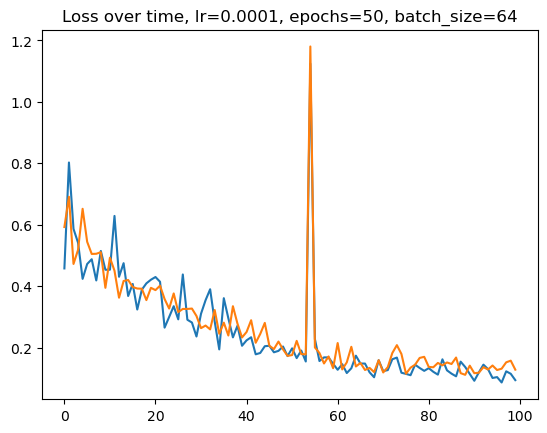

In [17]:
plt.plot(losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.title("Loss over time, lr=0.0001, epochs=50, batch_size=64")

In [18]:
labels_val = np.array([])
predicted_val = np.array([])

for i, data in tqdm(enumerate(val_loader), total=len(val_loader)-1):
    input_data = data[0]
    left_label = data[1]

    output = feature_extractor(input_data.to(device))
    output = regression_head(output["features.2"])

    if labels_val.shape[0] == 0:
        labels_val = left_label.detach().cpu().numpy()
        predicted_val = output.detach().cpu().numpy()
    else:
        labels_val = np.vstack((labels_val, left_label.detach().cpu().numpy()))
        predicted_val = np.vstack((predicted_val, output.detach().cpu().numpy()))

28it [00:18,  1.53it/s]                        


In [19]:
from scipy.stats import pearsonr as corr

# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(predicted_val.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(predicted_val.shape[1])):
    lh_correlation[v] = corr(predicted_val[:,v], labels_val[:,v])[0]

score = (np.median(lh_correlation)**2) * 100
print(score)

100%|██████████| 18981/18981 [00:01<00:00, 10985.53it/s]

85.43242045935322
